In [30]:
# ────────────────────────────────────────
# Cell 1 — Imports & robust load helper
# ────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline    import Pipeline
from sklearn.ensemble    import IsolationForest
from sklearn.metrics     import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

def load_and_prepare(path_csv, path_labels=None):
    """
    Read a transactions CSV (and optional labels JSON), clean it,
    and add hour/day features. Works whether 'amount' is a string
    with '$' or already numeric.
    """
    df = pd.read_csv(
        path_csv,
        usecols=["id", "date", "amount", "merchant_city", "mcc"]
    )

    df["date"] = pd.to_datetime(df["date"])

    # --- robust 'amount' cleaning -------------------------------
    if pd.api.types.is_numeric_dtype(df["amount"]):
        df["amount"] = df["amount"].astype(float)
    else:
        df["amount"] = (
            df["amount"]
              .astype(str)
              .str.replace(r"[$,]", "", regex=True)
              .astype(float)
        )

    # rename + derived features
    df = df.rename(columns={"id": "transaction_id",
                            "merchant_city": "location"})
    df["hour_of_day"] = df["date"].dt.hour
    df["day_of_week"] = df["date"].dt.weekday

    if path_labels is not None:
        lbl = (pd.read_json(path_labels)
                 .reset_index()
                 .rename(columns={"index": "transaction_id"})
                 .replace({"target": {"Yes": 1, "No": 0}}))
        df = df.merge(lbl, on="transaction_id")

    # inject target column if it exists
    df_target = pd.read_csv(path_csv)
    if "target" in df_target.columns:
        df["target"] = df_target["target"].astype(int)

    return df


In [31]:
# ───────────────────────────────
# Cell 2 — TRAIN on Kaggle
# ───────────────────────────────
kag_tx_file     = "assets/kaggle_data/transactions_data.csv"
kag_labels_file = "assets/kaggle_data/train_fraud_labels.json"   # contains 'Yes'/'No'

train_df = load_and_prepare(kag_tx_file, kag_labels_file)

y_train = train_df["target"]
X_train = train_df.drop(columns=["transaction_id", "date", "target"])

cat_cols = ["location", "mcc"]
num_cols = ["amount", "hour_of_day", "day_of_week"]

pre = ColumnTransformer(
        transformers=[
            ("cat",
             OneHotEncoder(handle_unknown="ignore",
                           sparse_output=True,
                           dtype=np.int8),
             cat_cols),
            ("num", StandardScaler(), num_cols)
        ],
        sparse_threshold=0.3
)

iso = IsolationForest(
        n_estimators=200,
        max_samples=1.0,
        contamination=0.1,
        n_jobs=-1,
        random_state=42
)

clf = Pipeline([("pre", pre),
                ("iso", iso)])

clf.fit(X_train)

# (optional) quick sanity-check on training set
train_pred = np.where(clf.predict(X_train) == -1, 1, 0)
print("Training F1:", f1_score(y_train, train_pred))


/var/folders/gd/d2vxxv2x60j28jw85n3wg5dw0000gn/T/ipykernel_47083/3671967283.py:51: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"target": {"Yes": 1, "No": 0}}))


Training F1: 0.001229326965596533


Accuracy : 0.911
Precision: 0.026378896882494004
Recall   : 0.22
F1       : 0.047109207708779445


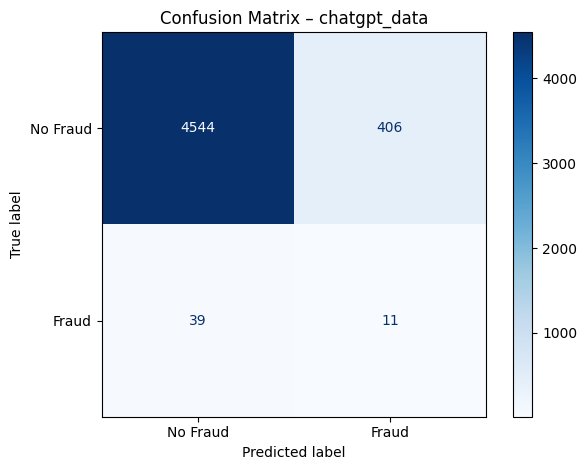

In [32]:
# ───────────────────────────────
# Cell 3 — TEST on chatgpt_data
# ───────────────────────────────
test_tx_file = "assets/chatgpt_data/transactions_o3_2_test.csv"
# If you *have* a labels JSON for this set, put its path below; else leave None
test_labels_file = None    # e.g. "assets/chatgpt_data/o3_labels.json"

test_df = load_and_prepare(test_tx_file, test_labels_file)

has_labels = "target" in test_df.columns
if has_labels:
    y_test = test_df["target"]

X_test = test_df.drop(columns=["transaction_id", "date"] +
                                (["target"] if has_labels else []))

# ---------- predict ----------
y_pred = np.where(clf.predict(X_test) == -1, 1, 0)

# ---------- metrics ----------
if has_labels:
    print("Accuracy :",  accuracy_score(y_test, y_pred))
    print("Precision:",  precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :",  recall_score(y_test, y_pred))
    print("F1       :",  f1_score(y_test, y_pred))

    cm   = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Fraud", "Fraud"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix – chatgpt_data")
    plt.tight_layout()
    plt.show()
else:
    print("Predictions generated (no ground-truth labels supplied).")
